# Stock Prediction Using LSTM

<img src = 'https://www.usnews.com/dims4/USNEWS/85cf3cc/2147483647/thumbnail/640x420/quality/85/?url=http%3A%2F%2Fmedia.beam.usnews.com%2Fd8%2F17%2F754293f84bc69ddfbffaa5793cae%2F190411-stockmarket-stock.jpg' width="400">

In this project, a simple LSTM neural network will predict future change in the stock prices of Alphabet (GOOG). Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems. The stock dataset was obtained from [Kaggle](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs).


In [1]:
from google.colab import drive  # for Google Colab
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import itertools
import datetime
from operator import itemgetter
from math import sqrt
import torch
import torch.nn as nn
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Load Data

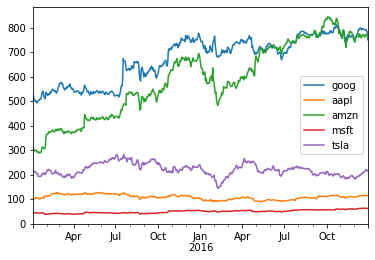

In [3]:
dir = "/content/drive/MyDrive/Colab Notebooks/Data"
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        df_temp = pd.read_csv(dir + "/Stocks/{}.us.txt".format(symbol), index_col='Date',
                              parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

dates = pd.date_range('2015-01-02', '2016-12-31', freq='B')
symbols = ['goog', 'aapl', 'amzn', 'msft', 'tsla']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.interpolate().plot()
plt.show()

In [4]:
df.head()

,goog,aapl,amzn,msft,tsla
2015-01-02,524.81,103.50,308.52,43.555,219.31
2015-01-05,513.87,100.58,302.19,43.154,210.09
2015-01-06,501.96,100.59,295.29,42.520,211.28
2015-01-07,501.10,102.01,298.42,43.062,210.95
2015-01-08,502.68,105.93,300.46,44.329,210.62


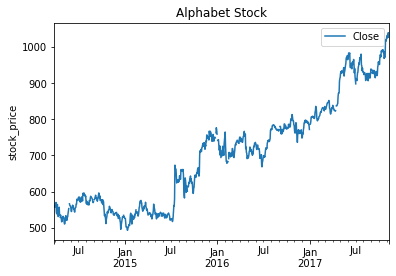

In [5]:
dates = pd.date_range('2014-03-27', '2017-11-10', freq='B')
df_date = pd.DataFrame(index=dates)
df_goog = pd.read_csv(dir + "/Stocks/goog.us.txt", parse_dates=True, index_col=0)
df_goog = df_date.join(df_goog)
df_goog = df_goog[['Close']]

df_goog.plot()
plt.ylabel("stock_price")
plt.title("Alphabet Stock")
plt.show()

In [6]:
df_goog = df_goog.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
nd_goog = scaler.fit_transform(df_goog)

def dataload(data_raw, seq_len):
    data = []

    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)
    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0] - test_size

    x_train = data[:train_size, :-1, :]
    y_train = data[:train_size, -1, :]
    x_test = data[train_size : train_size+test_size, :-1, :]
    y_test = data[train_size: train_size+test_size, -1, :]
    # inp1: which index(i) in raw data
    # inp2: which part of sequence(i to i + seq_len)
    # inp3: 'Close' ndarray

    return x_train, y_train, x_test, y_test

seq_len = 20
x_train, y_train, x_test, y_test = dataload(nd_goog, seq_len)
print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)

print(x_train.size(), y_train.size())

x_train.shape =  (742, 19, 1)
y_train.shape =  (742, 1)
x_test.shape =  (185, 19, 1)
y_test.shape =  (185, 1)
torch.Size([742, 19, 1]) torch.Size([742, 1])


In [7]:
n_steps = seq_len - 1
batch_size = 742
epochs = 100

train = torch.utils.data.TensorDataset(x_train ,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

## Train LSTM Network

In [8]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers).to(device)
loss_fn = torch.nn.MSELoss(size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [9]:
hist = np.zeros(epochs)
seq_dim = seq_len - 1

for t in range(epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  10 MSE:  0.04599025472998619
Epoch  20 MSE:  0.012709897942841053
Epoch  30 MSE:  0.008051012642681599
Epoch  40 MSE:  0.005265312269330025
Epoch  50 MSE:  0.004085599910467863
Epoch  60 MSE:  0.003436960279941559
Epoch  70 MSE:  0.0031044648494571447
Epoch  80 MSE:  0.0029210620559751987
Epoch  90 MSE:  0.0027749529108405113


## Test Data

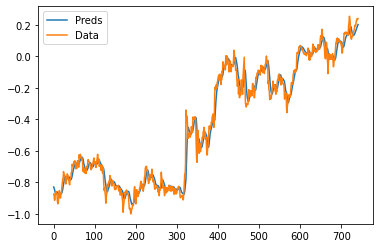

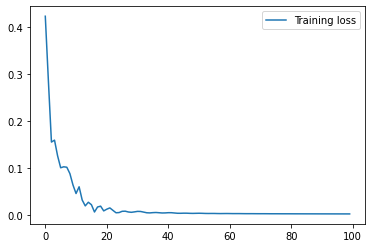

In [10]:
y_train = y_train.detach().cpu()
y_train_pred = y_train_pred.detach().cpu()

plt.plot(y_train_pred.numpy(), label="Preds")
plt.plot(y_train.numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [11]:
np.shape(y_train_pred)

torch.Size([742, 1])

In [12]:
# make predictions
y_test_pred = model(x_test)

y_test = y_test.detach().cpu()
y_test_pred = y_test_pred.detach().cpu()

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

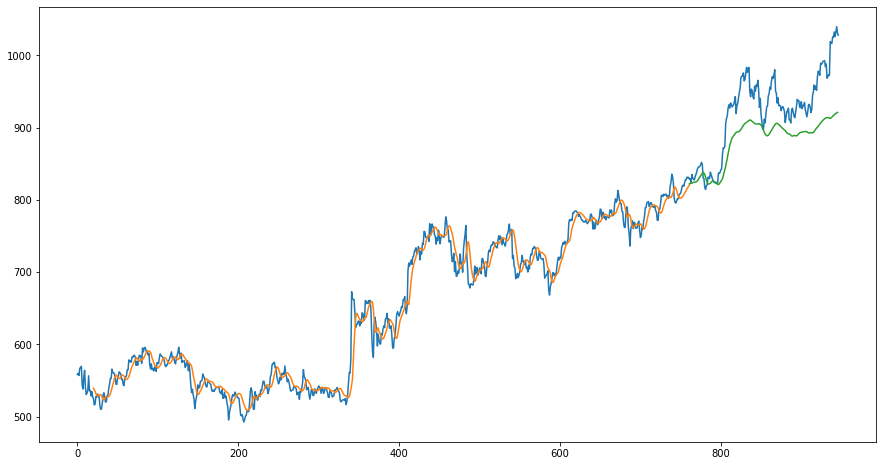

In [15]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(nd_goog)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_len:len(y_train_pred)+seq_len, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(nd_goog)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+seq_len-1:len(nd_goog)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(nd_goog))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Overall, the model reached a reasonable conclusion of Google's stock trend over a few years. However, the model may be overfitting due to the small size of data available.